In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import pcalg
import networkx as nx
from structure_learning.samplers import PartitionMCMC
from structure_learning.data import SyntheticDataset, Data
from structure_learning.distributions import Distribution, OPAD
from structure_learning.data_structures import DAG
from structure_learning.scores import BGeScore, BDeuScore
from structure_learning.evaluation.metrics import KLD, JSD, MAE, MSE, SHD

In [3]:
np.random.seed(1000)

num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 10000
degree = 2
synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

00000 00000 00000 11101 00100


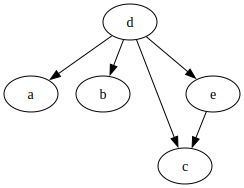

In [4]:
# visualise ground truth DAG
synthetic_data.graph.plot()

In [5]:
# setup mcmc
M = PartitionMCMC(max_iter=100000, data=synthetic_data.data, score_object='bge', searchspace="FULL", result_type='distribution', plus1=False)

In [6]:
# run experiment
mcmc_results, acceptance = M.run()
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.1165


/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


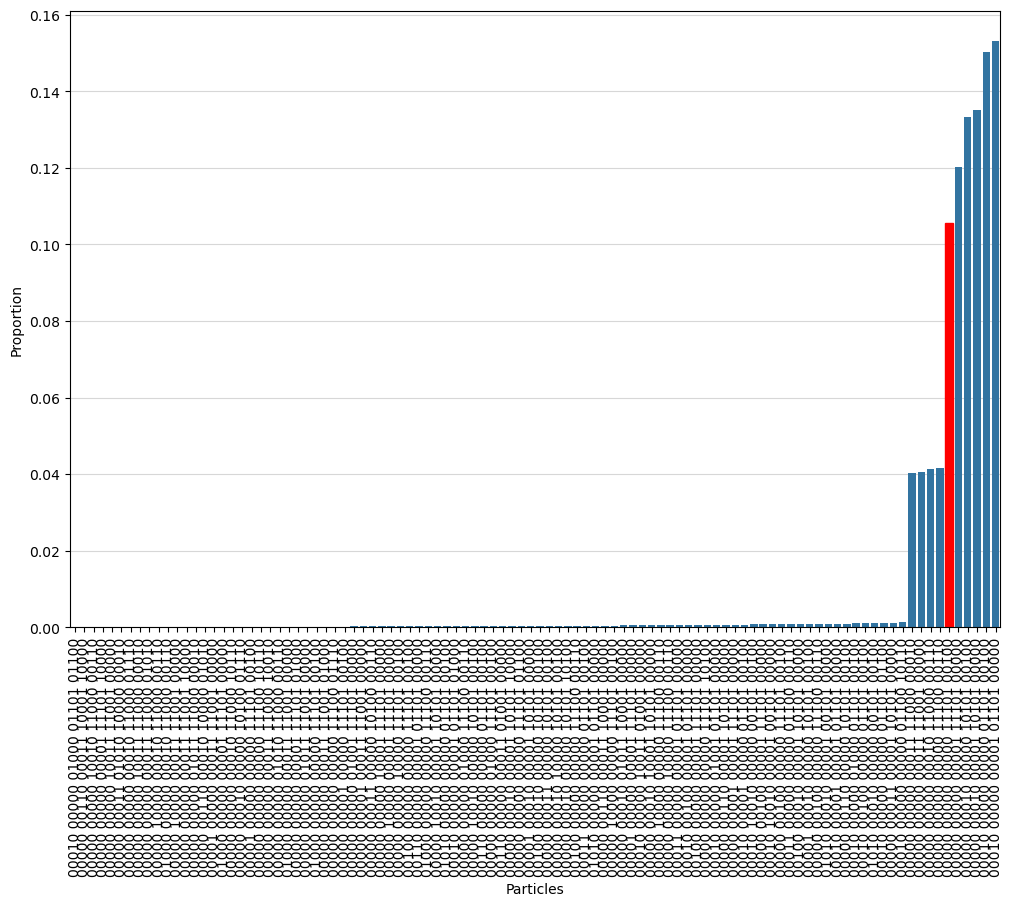

In [7]:
from matplotlib import pyplot as plt

key = synthetic_data.graph.to_key()
plt.rcParams['figure.figsize'] = 12,8
bars, keys, counts = mcmc_results.plot(sort=True, normalise=True, limit=100)
bars.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')

In [8]:
from structure_learning.distributions import Distribution
from structure_learning.scores import BGeScore, BDeuScore

true_dist = Distribution.compute_distribution(synthetic_data.data, score=BGeScore)

/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


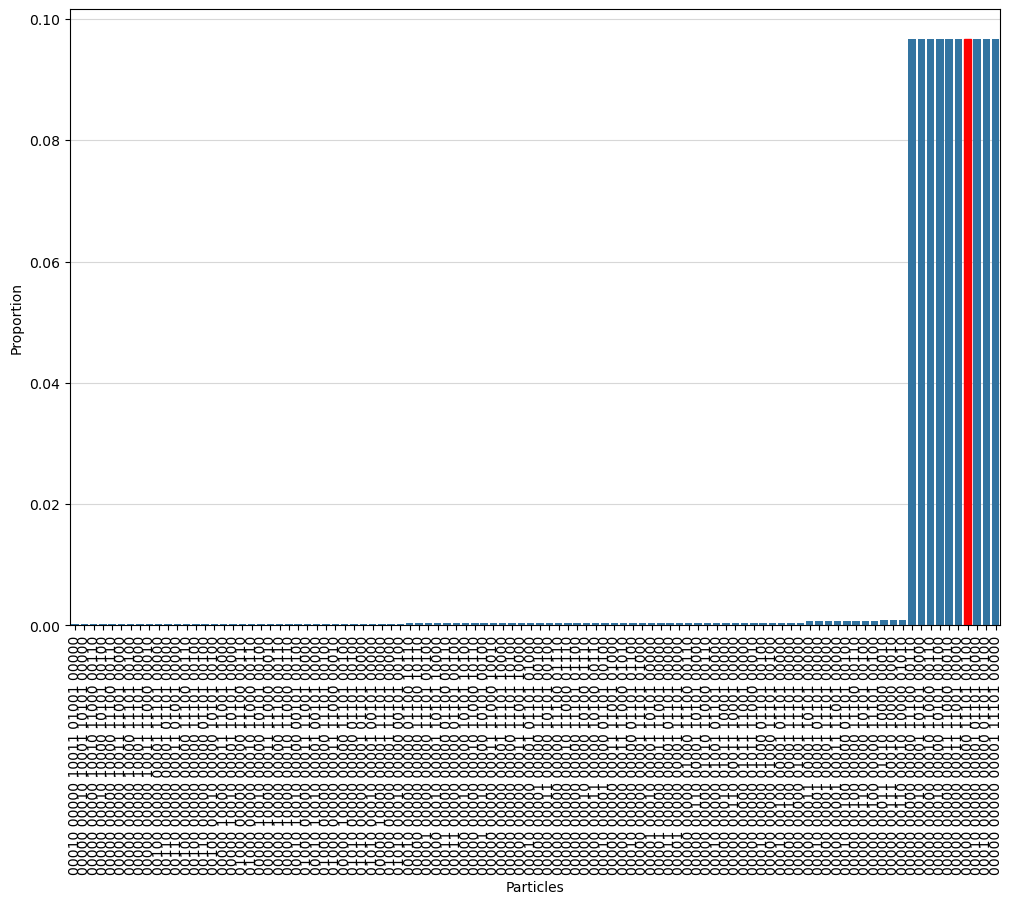

In [9]:
bars2, keys, counts = true_dist.plot(prop='p', sort=True, limit=100)
bars2.containers[0][np.where(np.array(keys)==key)[0][0]].set_color('red')

In [10]:
opad_results = mcmc_results.to_opad()
opad_plus_results = mcmc_results.to_opad(plus=True)

Adding rejected particles


/Users/165421/Documents/code/structure_learning/examples/../src/structure_learning/distributions/distribution.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(particles[-limit:], rotation=90)


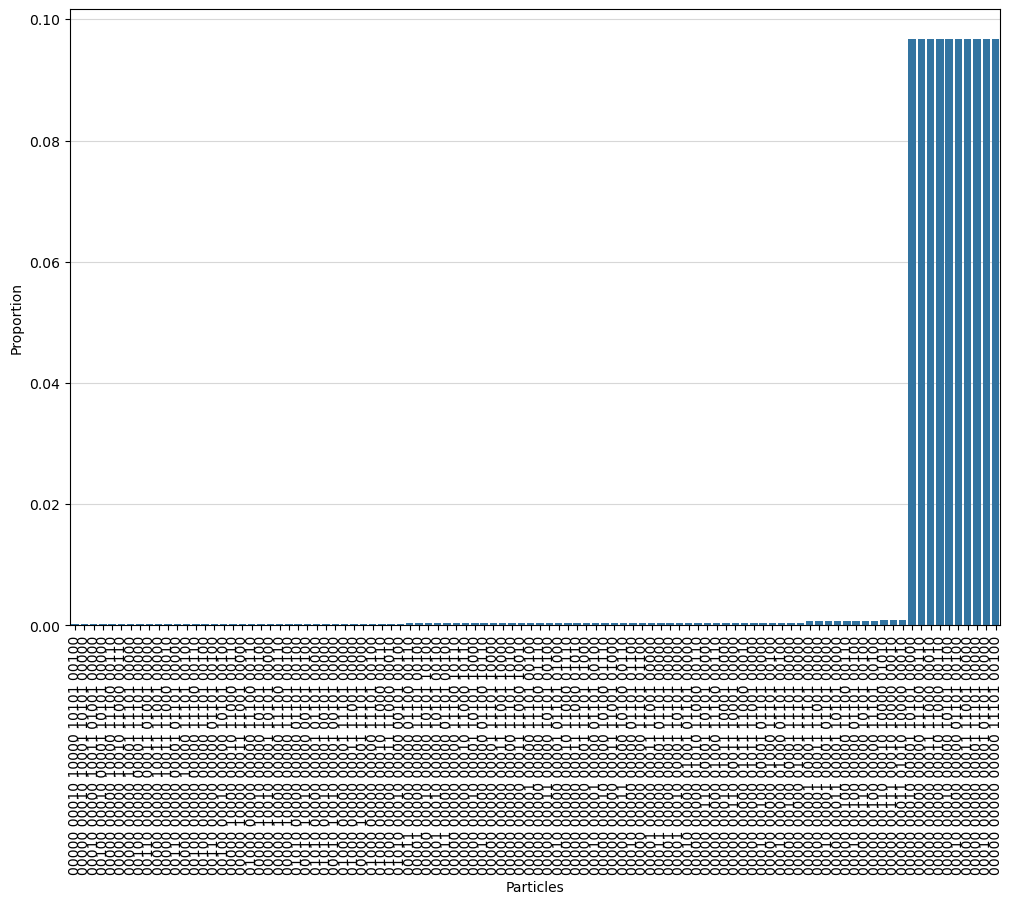

In [11]:
_ = opad_results.plot(limit=100)

### KLD

In [12]:
kld = KLD()
kld_mcmc = kld.compute(mcmc_results, true_dist)
kld_opad = kld.compute(opad_results, true_dist)
kld_opad_plus = kld.compute(opad_plus_results, true_dist)

print(kld_mcmc, kld_opad, kld_opad_plus)

0.13823386550718209 0.0006023243991826717 0.00014098909959418606


### JSD

In [13]:
jsd = JSD()
jsd_mcmc = jsd.compute(mcmc_results, true_dist)
jsd_opad = jsd.compute(opad_results, true_dist)
jsd_opad_plus = jsd.compute(opad_plus_results, true_dist)

print(jsd_mcmc, jsd_opad, jsd_opad_plus)

0.036261046763062584 0.0002086539788569198 4.881336636741619e-05


## MSE

In [14]:
mse = MSE()
mse_mcmc = mse.compute(mcmc_results, true_dist)
mse_opad = mse.compute(opad_results, true_dist)
mse_opad_plus = mse.compute(opad_plus_results, true_dist)

print(mse_mcmc, mse_opad, mse_opad_plus)

7.50023264795318e-07 3.7630626381109725e-12 7.090999330652958e-14


### MAE

In [15]:
mae = MAE()
mae_mcmc = mae.compute(mcmc_results, true_dist)
mae_opad = mae.compute(opad_results, true_dist)
mae_opad_plus = mae.compute(opad_plus_results, true_dist)

print(mae_mcmc, mae_opad, mae_opad_plus)

1.5833990016954785e-05 4.115717441176883e-08 9.646631313077473e-09


### SHD

In [16]:
shd = SHD()
shd_mcmc = shd.compute(mcmc_results, synthetic_data.graph)
shd_opad = shd.compute(opad_results, synthetic_data.graph)
shd_opad_plus = shd.compute(opad_plus_results, synthetic_data.graph)

print(shd_mcmc, shd_opad, shd_opad_plus)

0.009618054504386462 0.010552118609698955 0.0020338760016519477
